#Прогнозирование акций Лукойл

In [0]:
#Загружаем библиотеки

import pandas as pd #Пандас
import matplotlib.pyplot as plt #Отрисовка графиков
from tensorflow.keras import utils #Для to_categorical
import numpy as np #Numpy
from keras.optimizers import Adam #Оптимизатор
from keras.models import Sequential, Model #Два варианты моделей
from keras.layers import concatenate, Input, Dense, Dropout, BatchNormalization, Flatten, Conv1D, Conv2D, CuDNNLSTM #Стандартные слои
from google.colab import files #Загрузка файлов
from sklearn.preprocessing import StandardScaler, MinMaxScaler #Нормировщики

# Рисовать графики сразу же
%matplotlib inline

from google.colab import files
import os

Using TensorFlow backend.


In [0]:
#Загружаем архив с текстами с FTP/HTTP
def loadfiles(filename, fullpath):
  loaded = True
  if os.path.isfile(filename):
      print("File \"", filename, "\" has already downloaded.")
  else:
    print("Start downloading", filename)
    !wget $fullpath
    !unzip $filename 
    loaded = False
  return loaded    
   
!ls

sample_data


In [0]:
URL = "http://www.bizkit.ru/wp-content/uploads/COLAB/"
filename = "onestock_oneminute.zip"
fullpath = URL + filename
print(fullpath)
loaded = loadfiles(filename, fullpath) 

http://www.bizkit.ru/wp-content/uploads/COLAB/onestock_oneminute.zip
Start downloading onestock_oneminute.zip
--2019-12-15 06:20:17--  http://www.bizkit.ru/wp-content/uploads/COLAB/onestock_oneminute.zip
Resolving www.bizkit.ru (www.bizkit.ru)... 92.53.96.170, 2a03:6f00:1::5c35:60aa
Connecting to www.bizkit.ru (www.bizkit.ru)|92.53.96.170|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 25095424 (24M) [application/zip]
Saving to: ‘onestock_oneminute.zip’

onestock_oneminute. 100%[===================>]  23.93M  8.85MB/s    in 2.7s    

2019-12-15 06:20:20 (8.85 MB/s) - ‘onestock_oneminute.zip’ saved [25095424/25095424]

Archive:  onestock_oneminute.zip
  inflating: 02_03.csv               
  inflating: 04_05.csv               
  inflating: 06_07.csv               
  inflating: 08_09.csv               
  inflating: 10_11.csv               
  inflating: 12_13.csv               
  inflating: 14_15.csv               
  inflating: 16_17.csv               
  inflating:

In [0]:
#Загружаем файл базы
#files.upload()
#!ls

In [0]:
#!ls #Проверяем загруженные файлы

In [0]:
#Считываем данные с помощью pandas
base_data = pd.read_csv('18_19.csv', sep=';')
print(base_data.shape)

(217947, 7)


In [0]:
#Выводим пять первых строк
print(base_data.head())

         DATE      TIME    OPEN     MAX     MIN   CLOSE  VOLUME
0  03.01.2018  10:00:00  3341.0  3356.0  3340.0  3355.0    6088
1  03.01.2018  10:01:00  3355.0  3359.0  3353.0  3353.0    1624
2  03.01.2018  10:02:00  3351.5  3357.5  3351.5  3357.5     722
3  03.01.2018  10:03:00  3354.5  3360.0  3354.5  3358.0    3034
4  03.01.2018  10:04:00  3358.0  3360.0  3351.5  3360.0    1427


In [0]:
#Выцепялем numpy значения .values
#И выводим нулевой
txt = base_data.values[2]
print(txt)

['03.01.2018' '10:02:00' 3351.5 3357.5 3351.5 3357.5 722]


In [0]:
#Загружаем выборку
def getData(df):
  data = df
  data = data.drop(columns=['DATE', 'TIME'], axis=1).astype(float)

  return data

#Получаем данные из файла
def getDataFromFile(fileName):
  df = pd.read_csv(fileName, sep=';') #Считываем файл с помощью pandas
  return getData(df) #Возвращаем считанные данные из файла

In [0]:
#Считываем данные из двух файлов
#16-17 год и 18-19 год
data16_17 = getDataFromFile('16_17.csv')
data18_19 = getDataFromFile('18_19.csv')
print(data16_17.head(5))
print(data16_17.shape)

     OPEN     MAX     MIN   CLOSE  VOLUME
0  2351.0  2355.8  2350.0  2350.0  2547.0
1  2352.9  2355.7  2350.0  2355.7   195.0
2  2355.6  2356.0  2351.4  2354.1   257.0
3  2354.5  2355.0  2351.2  2353.7   763.0
4  2353.1  2353.9  2353.1  2353.6   231.0
(263925, 5)


In [0]:
#Объединяем базы из двух файлов
data = data16_17.append(data18_19)
print(data.head(5))
data = np.array(data) #Превращаем в numpy массив
print(data.shape)
print(max(data[:, 4]))

     OPEN     MAX     MIN   CLOSE  VOLUME
0  2351.0  2355.8  2350.0  2350.0  2547.0
1  2352.9  2355.7  2350.0  2355.7   195.0
2  2355.6  2356.0  2351.4  2354.1   257.0
3  2354.5  2355.0  2351.2  2353.7   763.0
4  2353.1  2353.9  2353.1  2353.6   231.0
(481872, 5)
4296341.0


In [0]:
#Сравниваем размеры
print(data16_17.shape) #Выводим размер первой базы
print(data18_19.shape) #Выводим размер второй базы
print(data.shape) #Выводим размер суммарной базы

(263925, 5)
(217947, 5)
(481872, 5)


/usr/local/lib/python3.6/dist-packages/IPython/core/pylabtools.py:125: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


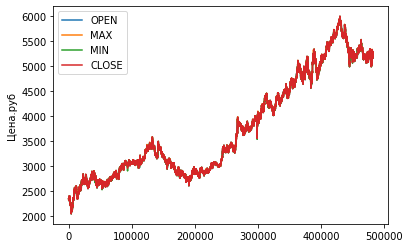

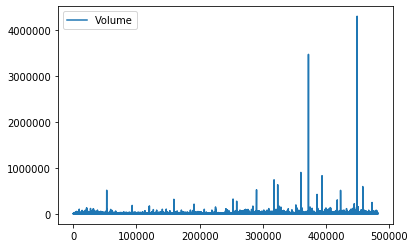

In [0]:
#Отображаем исходные данные от точки start и длиной step
start = 0 #С какой точки начинаем
step = data.shape[0] #Сколько точек отрисуем

#Заполняем текстовые названия каналов данных
chanelNames = list(data16_17.columns) # ['Open', 'Max', 'Min', 'Close', 'Volume']

#Рисуем все графики данных
#ЧЕтыре основных канала - open, max, min, close
for i in range(4):
  #Отрисовываем часть данных
  #От начальной точки, до начальной точки + размер шага отрисовки
  plt.plot(data[start:start+step, i], 
          label=chanelNames[i])
plt.ylabel('Цена.руб')
plt.legend()
plt.show()

#Канал volume
plt.plot(data[start:start+step,4], label="Volume")
plt.legend()
plt.show()

**Функция загрузки данных**

In [0]:
def DataNormalization(data, Channels, Normalization):
  #Выбираем тип нормализации x
  #0 - нормальное распределение
  #1 - нормирование до отрезка 0-1
  if (Normalization == 0):
    scaler = StandardScaler()
  else:
    scaler = MinMaxScaler()
  
  #Берём только те каналы, которые указаны в аргументе функции
  resData = data[:,Channels]
  #Обучаем нормировщик
  scaler.fit(resData)
  #Нормируем данные
  resData = scaler.transform(resData)
  return (resData, scaler)

In [0]:
#Функция "раскусывания" данных для временных рядов
#data - данные
#xLen - размер фрема, по которому предсказываем
#xChannels - лист, номера каналов, по которым делаем анализ
#yChannels - лист, номера каналов, которые предсказываем
#stepsForward - на сколько шагов предсказываем в будущее
#если 1 - то на 1 шаг, можно использовать только при одном канале, указанном в yChannels
#xNormalization - нормализация входных каналов, 0 - нормальное распределение, 1 - к отрезку [0;1]
#yNormalization - нормализация прогнозируемых каналов, 0 - нормальное распределение, 1 - к отрезку [0;1]
#returnFlatten - делать ли одномерный вектор на выходе для Dense сетей
#valLen - сколько примеров брать для проверочной выборки (количество для обучающей посчитается автоматиески)
#convertToDerivative - bool, преобразовывали ли входные сигналы в производнуюa
def getXTrainFromTimeSeries(data, xLen, xChannels, yChannels, stepsForward, xNormalization, yNormalization, returnFlatten, valLen, convertToDerivative):
  
  #Если указано превращение данных в производную
  #То вычитаем поточечно из текущей точки предыдущую
  if (convertToDerivative):
    data = np.array([(d[1:]-d[:-1]) for d in data.T]).copy().T
  
  #Нормализуем x
  (xData, xScaler) = DataNormalization(data, xChannels, xNormalization)

  #Нормализуем y
  (yData, yScaler) = DataNormalization(data, yChannels, yNormalization)

  #Формируем xTrain
  #Раскусываем исходный ряд на куски xLen с шагом в 1
  xTrain = np.array([xData[i:i + xLen, xChannels] for i in range(xData.shape[0] - xLen + 1 - stepsForward)])
  
  #Формируем yTrain
  #Берём stepsForward шагов после завершения текущего x
  if (stepsForward > 1):
    yTrain = np.array([yData[i:i + stepsForward, yChannels] for i in range(xLen, yData.shape[0] + 1 - stepsForward)])
  else:
    yTrain = np.array([yData[i, yChannels] for i in range(xLen, yData.shape[0] + 1 - stepsForward)])

  #Расчитываем отступ между обучающими о проверочными данными
  #Чтобы они не смешивались
  xTrainLen = xTrain.shape[0]
  bias = xLen + stepsForward + 2

  #Берём из конечной части xTrain проверочную выборку
  xVal = xTrain[xTrainLen-valLen:]
  yVal = yTrain[xTrainLen-valLen:]
  
  #Оставшуюся часть используем под обучающую выборку
  xTrain = xTrain[:xTrainLen-valLen-bias]
  yTrain = yTrain[:xTrainLen-valLen-bias]

  #Если в функцию передали вернуть flatten сигнал (для Dense сети)
  #xTrain и xVal превращаем в flatten
  if (returnFlatten > 0):
    xTrain = np.array([x.flatten() for x in xTrain])
    xVal = np.array([x.flatten() for x in xVal])

  return (xTrain, yTrain), (xVal, yVal), (xScaler, yScaler)

In [4]:
#Формируем параметры загрузки данных
xLen = 300 #Анализируем по 300 прошедшим точкам 
stepsForward = 1 #Предсказываем на 1 шаг вперёд
xChannels = range(data.shape[1]) #Используемвсе входные каналы
yChannels = [0] #Предказываем только open канал
xNormalization = 0 #Нормируем входные каналы стандартным распределением
yNormalization = 0#Нормируем выходные каналы стандартным распределением
valLen = 30000 #Используем 30.000 записей для проверки0
returnFlatten = 1 #Вернуть одномерные вечеторы
convertToDerivative = 0 #Не превращать в производную

#Загружаем данные
(xTrain, yTrain), (xVal, yVal), (xScaler, yScaler) = getXTrainFromTimeSeries(data, xLen, xChannels, yChannels, stepsForward, xNormalization, yNormalization, returnFlatten, valLen, convertToDerivative)

#Выводим размеры данных для проверки
print(xTrain.shape)
print(yTrain.shape)
print(xVal.shape)
print(yVal.shape)

NameError: name 'data' is not defined

#Визуализация результатов

In [2]:
#Функция рассчитываем результаты прогнозирования сети
#В аргументы принимает сеть (currModel) и проверочную выборку
#Выдаёт результаты предсказания predVal
#И правильные ответы в исходной размерности yValUnscaled (какими они были до нормирования)
def getPred(currModel, xVal, yVal, yScaler):
  #Предсказываем ответ сети по проверочной выборке
  #И возвращаем исходны масштаб данных, до нормализации
  predVal = yScaler.inverse_transform(currModel.predict(xVal))
  yValUnscaled = yScaler.inverse_transform(yVal)
  
  return (predVal, yValUnscaled)

#Функция расёта коэффициента корреляции Пирсона двух одномерных векторов
def correlate(a, b):
  return np.corrcoef(a, b)[0, 1] 

#Функция визуализирует графики, что предсказала сеть и какие были правильные ответы
#start - точка с которой начинаем отрисовку графика
#step - длина графика, которую отрисовываем
#channel - какой канал отрисовываем
def showPredict(start, step, channel, predVal, yValUnscaled):
  plt.plot(predVal[start:start+step, channel], 
           label='Прогноз')
  plt.plot(yValUnscaled[start:start+step, channel], 
           label='Базовый ряд')
  plt.xlabel('Время')
  plt.ylabel('Значение Close')
  plt.legend()
  plt.show()

In [3]:
#Функция строит корреляцию прогнозированного сигнала с правильным
#Смещая на различное количество шагов назад
#Для проверки появления эффекта автокорреляции
#channels - по каким каналам отображать корреляцию
#corrSteps - на какое количество шагов смещать сигнал назад для рассчёта корреляции
def showCorr(channels, corrSteps, predVal, yValUnscaled):
  #Проходим по всем каналам
  for ch in channels:
    corr = [] #Создаём пустой лист, в нём будут корреляции при смещении на i рагов обратно
    yLen = yValUnscaled.shape[0] #Запоминаем размер проверочной выборки

    #Постепенно увеличиваем шаг, насколько смещаем сигнал для проверки автокорреляции
    for i in range(corrSteps):
      #Получаем сигнал, смещённый на i шагов назад
      #predVal[i:, ch]
      #Сравниваем его с верными ответами, без смещения назад
      #yValUnscaled[:yLen-i,ch]
      #Рассчитываем их корреляцию и добавляем в лист
      corr.append(correlate(yValUnscaled[:yLen-i,ch], predVal[i:, ch]))

    #Отображаем график корреляций для данного шага
    plt.plot(corr, label='предсказание на ' + str(ch+1) + ' шаг')

  plt.xlabel('Время')
  plt.ylabel('Значение')
  plt.legend()
  plt.show()

In [0]:
a = np.arange(12)
print(a)
print(a[:3])
print(a[3:])

[ 0  1  2  3  4  5  6  7  8  9 10 11]
[0 1 2]
[ 3  4  5  6  7  8  9 10 11]


#Одномерная свертка

In [0]:
#Формируем параметры загрузки данных
xLen = 300
stepsForward = 1
xChannels = range(data.shape[1])
yChannels = [0]
xNormalization = 0
yNormalization = 0
valLen = 30000
returnFlatten = 0 #Возвращаем двумерные данные для свёртки
convertToDerivative = 0

#Загружаем данные
(xTrain, yTrain), (xVal, yVal), (xScaler, yScaler) = getXTrainFromTimeSeries(data, xLen, xChannels, yChannels, stepsForward, xNormalization, yNormalization, returnFlatten, valLen, convertToDerivative)

#Выводим размеры данных для проверки
print(xTrain.shape)
print(yTrain.shape)
print(xVal.shape)
print(yVal.shape)

(451269, 300, 5)
(451269, 1)
(30000, 300, 5)
(30000, 1)


In [0]:
modelC = Sequential()

modelC.add(Conv1D(50, 5, input_shape = (xTrain.shape[1], xTrain.shape[2]), activation="linear"))
modelC.add(Flatten())
modelC.add(Dense(10, activation="linear"))
modelC.add(Dense(yTrain.shape[1], activation="linear"))

modelC.compile(loss="mse", optimizer=Adam(lr=1e-4))

history = modelC.fit(xTrain, 
                    yTrain, 
                    epochs=20, 
                    batch_size=20, 
                    verbose=1,
                    validation_data=(xVal, yVal))

plt.plot(history.history['loss'], 
         label='Средняя абсолютная ошибка на обучающем наборе')
plt.plot(history.history['val_loss'], 
         label='Средняя абсолютная ошибка на проверочном наборе')
plt.ylabel('Средняя ошибка')
plt.legend()
plt.show()

ValueError: ignored

In [0]:
#Прогнозируем данные текущей сетью
currModel = modelC
(predVal, yValUnscaled) = getPred(currModel, xVal, yVal, yScaler)

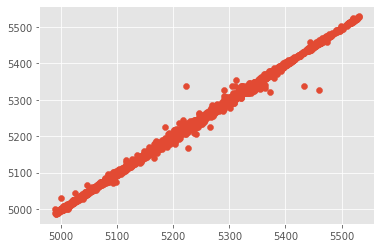

In [0]:
import matplotlib

matplotlib.style.use('ggplot')

#plt.figure(figsize=(12,12))
plt.scatter(predVal, yValUnscaled)
plt.show()

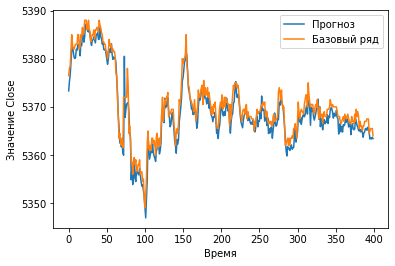

In [0]:
#Отображаем графики
showPredict(10000, 400, 0, predVal, yValUnscaled)

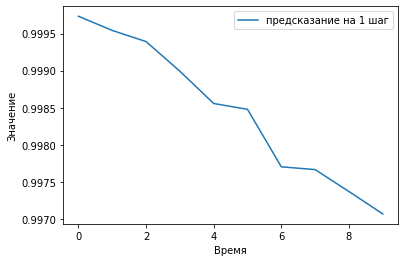

In [0]:
#Отображаем корреляцию

showCorr([0], 10, predVal, yValUnscaled)

In [0]:
a = np.arange(10)
b = np.arrange(10)
print(a)
print(a[2:])
print(a[:len(a) - 2])

[0 1 2 3 4 5 6 7 8 9]
[2 3 4 5 6 7 8 9]
[0 1 2 3 4 5 6 7]


In [0]:
def showCorr1(channels, max_shift, pred, orig):
  for ch in channels:
    corr = [] #Создаём пустой лист, в нём будут корреляции при смещении на i рагов обратно
    yLen = yValUnscaled.shape[0] #Запоминаем размер проверочной выборки

    for shift in range(max_shift):
      a = orig[shft:, ch] #Обрезаем сначала вектора на step, чтобы сделать смещение на step и сравнять длины
      b = pred[:shft, ch] #Обрезаем с конца вектора на step, чтобы сравнять длины. 
      corr.append(correlate(yValUnscaled[:yLen-i,ch], predVal[i:, ch]))

    #Отображаем график корреляций для данного шага
    plt.plot(corr, label='предсказание на ' + str(ch+1) + ' шаг')

  plt.xlabel('Время')
  plt.ylabel('Значение')
  plt.legend()
  plt.show()     

showCorr1(a, )





